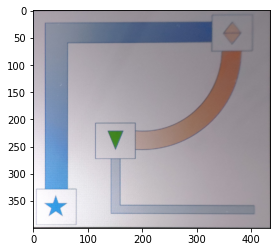

In [4]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
def cartesian_distance(x, y): return math.sqrt(x**2+y**2)

# frame = cv2.imread("Picture1.png")
frame = cv2.imread("Picture2.jpg")
frame = imutils.resize(frame, height=400)
imshow(frame)

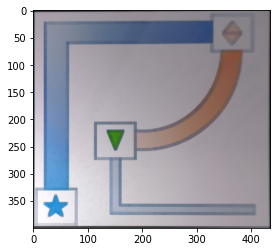

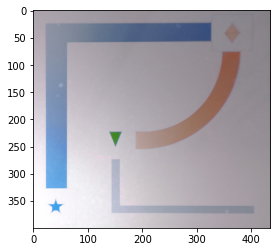

In [5]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
LUV = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(frame,kernel,iterations = 1)
dilation = cv2.dilate(frame,kernel,iterations = 1)
imshow(erosion)
imshow(dilation)

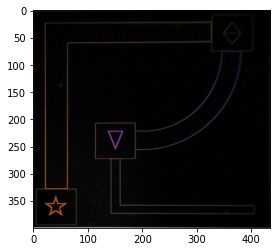

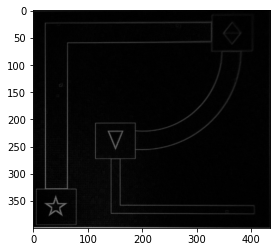

True

In [6]:
diff = cv2.absdiff(dilation, frame)
imshow(diff)
diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
imshow(diff)
cv2.imwrite("diff.jpg", diff)